## Adding RAG to workflow

Add a document database to a workflow

we’ll parse a resume and load it into a vector store, and use the agent to run basic queries against the documents. You’ll use LlamaParse to parse the documents.

## Importing libraries

In [1]:
from IPython.display import display, HTML
from llama_index.utils.workflow import draw_all_possible_flows
import os
from llama_index.core.workflow import (
    StartEvent,
    StopEvent,
    Workflow,
    step,
    Context
)

from llama_index.core.workflow import Event
import asyncio


## API for workflow

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
import os

def get_openai_api_key():
    """Retrieve the OpenAI API key from environment variables."""
    return os.getenv('OPEN_AI_KEY')

def get_llama_cloud_api_key():
    """Retrieve the Llama Cloud API key from environment variables."""
    return os.getenv('LLAMA_CLOUD_API')

def extract_html_content(filename):
    """Read an HTML file and wrap its content in a scrollable div."""
    try:
        with open(filename, 'r', encoding='utf-8') as file:
            html_content = file.read()
            html_content = f""" <div style="width: 100%; height: 800px; overflow: hidden;"> {html_content} </div>"""
            return html_content
    except Exception as e:
        raise Exception(f"Error reading file: {str(e)}")


You need nested async for this to work, so let's enable it here. It allows you to nest asyncio event loops within each other. 

*Note:* In asynchronous programming, the event loop is like a continuous cycle that manages the execution of code.

In [4]:
import nest_asyncio
nest_asyncio.apply()

You also need two API keys: 
- LLM like you we earlier;
- LlamaCloud API key to use LlamaParse to parse the PDFs.

LlamaParse is an advanced document parser that can read PDFs, Word files, Powerpoints, Excel spreadsheets, and extract information out of complicated PDFs into a form LLMs find easy to understand.

In [5]:
llama_cloud_api_key = get_llama_cloud_api_key()
llm_api_key = os.getenv('GROQ_API')

## Performing Retrieval-Augmented Generation (RAG) on a Resume Document

### 1. Parsing the Resume Document 

Let's start by parsing a resume.

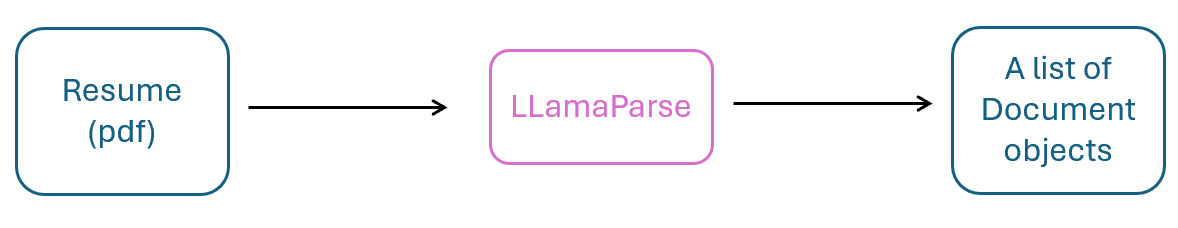

Using LLamaParse, we will transform the resume into a list of Document objects. By default, a Document object stores text along with some other attributes:
- metadata: a dictionary of annotations that can be appended to the text.
- relationships: a dictionary containing relationships to other Documents.
  

You can tell LlamaParse what kind of document it's parsing, so that it will parse the contents more intelligently. In this case, you tell it that it's reading a resume.

In [6]:
from llama_parse import LlamaParse

In [7]:
documents = LlamaParse(
    api_key=llama_cloud_api_key,
    result_type="markdown",
    content_guideline_instruction="This is a resume, gather related facts together and format it as bullet points with headers"
).load_data(
    "data/fake_resume.pdf",
)

Started parsing the file under job_id 688c5dcf-292d-443c-9aab-023915bd81eb


In [8]:
print(len(documents))
# resume has three pages so the length of doc is 3

3


In [9]:
print(documents[0])

Doc ID: 5b6cecb3-d763-47f8-85a6-cd45adae888b
Text: # Sarah Chen  Email: sarah.chen@email.com  LinkedIn:
linkedin.com/in/sarahchen  GitHub: github.com/sarahcodes  Portfolio:
sarahchen.dev  Location: San Francisco, CA  # Professional Summary
Innovative Full Stack Web Developer with 6+ years of experience
crafting scalable web applications and microservices. Specialized in
React, Node.js, and clou...


In [19]:
for i in documents[0]:
    print(i)
    
for i in documents[1]:
    print(i)
    
for i in documents[2]:
    print(i)

('id_', '62102dbf-f663-44ef-8013-7f3f8c712ca2')
('embedding', None)
('metadata', {})
('excluded_embed_metadata_keys', [])
('excluded_llm_metadata_keys', [])
('relationships', {})
('metadata_template', '{key}: {value}')
('metadata_separator', '\n')
('text_resource', MediaResource(embeddings=None, data=None, text="# Sarah Chen\n\nEmail: sarah.chen@email.com\n\nLinkedIn: linkedin.com/in/sarahchen\n\nGitHub: github.com/sarahcodes\n\nPortfolio: sarahchen.dev\n\nLocation: San Francisco, CA\n\n# Professional Summary\n\nInnovative Full Stack Web Developer with 6+ years of experience crafting scalable web applications and microservices. Specialized in React, Node.js, and cloud architecture. Proven track record of leading technical teams and implementing CI/CD pipelines that reduced deployment time by 40%. Passionate about clean code, accessibility, and mentoring junior developers.\n\n# Professional Experience\n\n# Senior Full Stack Developer\n\nTechFlow Solutions | San Francisco, CA January 202

In [21]:
print(documents[0].text)
print(documents[1].text)
print(documents[2].text)

# Sarah Chen

Email: sarah.chen@email.com

LinkedIn: linkedin.com/in/sarahchen

GitHub: github.com/sarahcodes

Portfolio: sarahchen.dev

Location: San Francisco, CA

# Professional Summary

Innovative Full Stack Web Developer with 6+ years of experience crafting scalable web applications and microservices. Specialized in React, Node.js, and cloud architecture. Proven track record of leading technical teams and implementing CI/CD pipelines that reduced deployment time by 40%. Passionate about clean code, accessibility, and mentoring junior developers.

# Professional Experience

# Senior Full Stack Developer

TechFlow Solutions | San Francisco, CA January 2022 - Present

- Architected and implemented a microservices-based e-commerce platform serving 100K+ daily users
- Led a team of 5 developers in rebuilding the company's flagship product using React and Node.js
- Implemented GraphQL API gateway that reduced API response times by 60%
- Established coding standards and review processes 

## Using embedding model

In [4]:
# pip install llama-index llama-index-embeddings-huggingface sentence-transformers

In [5]:
# pip install --upgrade llama-index sentence-transformers datasets

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for llama-index from https://files.pythonhosted.org/packages/b7/59/38019698f605d8f72f0e2a7b6ffdc9be536b8ecb54d052fea23363243ea2/llama_index-0.12.24-py3-none-any.whl.metadata
  Obtaining dependency information for datasets from https://files.pythonhosted.org/packages/7b/37/aaeec6b97c91833f1342c755beb0283f20b6ee208522af04daf49c251bdb/datasets-3.4.0-py3-none-any.whl.metadata
  Obtaining dependency information for llama-index-core<0.13.0,>=0.12.24 from https://files.pythonhosted.org/packages/fc/cb/014da862f7f53ad2c0b388426de06099526d7736613166c9af113d41d19f/llama_index_core-0.12.24.post1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/487.4 kB ? eta -:--:--
   --- ----------------------------------- 41.0/487.4 kB 991.0 kB/s eta 0:00:01
   ----- --------------------------------- 71.7/487.4 kB 991.0 kB/s eta 0:00:01
   ------- ----------------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [10]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings

Settings.embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-small-en-v1.5"
)

### 2. Creating a Vector Store Index

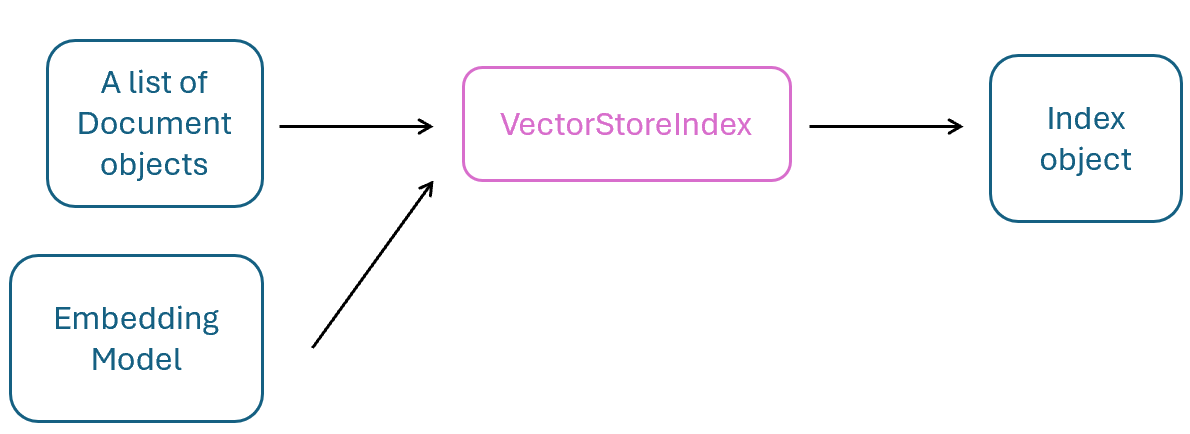

We'll now feed the Document objects to `VectorStoreIndex`. The `VectorStoreIndex` will use an embedding model to embed the text, i.e. turn it into vectors that you can search. You'll be using an embedding model provided by Hugging face.

The `VectorStoreIndex` will return an index object, which is a data structure that allows you to quickly retrieve relevant context for your query. It's the core foundation for RAG use-cases. You can use indexes to build Query Engines and Chat Engines which enables question & answer and chat over your data.

In [11]:
from llama_index.core import VectorStoreIndex

In [12]:
index = VectorStoreIndex.from_documents(
    documents
)

# we have already setup the embed model with setting so no need write the embedding model here

## Setting up LLM

In [13]:
from llama_index.llms.groq import Groq
from llama_index.core import Settings


os.environ["GROQ_API_KEY"] = os.getenv('GROQ_API')
llm = Groq(model="llama3-70b-8192", api_key=os.environ["GROQ_API_KEY"])
Settings.llm = llm

In [14]:
query_engine = index.as_query_engine(llm=llm, similarity_top_k=5)
response = query_engine.query("What is this person's name and what was their most recent job?")
print(response)

This person's name is Sarah Chen, and their most recent job was as a Senior Full Stack Developer at TechFlow Solutions.


## Storing the Index to Disk

Indexes can be persisted to disk. This is useful in a notebook that you might run several times! In a production setting, you would probably use a hosted vector store of some kind. Let's save your index to disk.

In [19]:
storage_dir = "./storage"

index.storage_context.persist(persist_dir=storage_dir) #this will create the storage folder with bunch of files which can be used later

## Loading the model

In [20]:
from llama_index.core import StorageContext, load_index_from_storage

You can check if your index has already been stored, and if it has, you can reload an index from disk using the `load_index_from_storage` method, like this:

In [21]:
# Check if the index is stored on disk
if os.path.exists(storage_dir):
    # Load the index from disk
    storage_context = StorageContext.from_defaults(persist_dir=storage_dir)
    restored_index = load_index_from_storage(storage_context)
else:
    print("Index not found on disk.")

In [23]:
response = restored_index.as_query_engine().query("what are the skill of this candidate")
print(response)

The skills of this candidate include:

Frontend: 
- React.js, Redux, Next.js, TypeScript
- Vue.js, Nuxt.js
- HTML5, CSS3, SASS/SCSS
- Jest, React Testing Library
- WebPack, Babel

Backend: 
- Node.js, Express.js
- Python, Django
- GraphQL, REST APIs
- PostgreSQL, MongoDB

Tools & Others: 
- Docker, Kubernetes
- AWS (EC2, S3, Lambda)
- Git, GitHub Actions
- Jenkins, CircleCI
- Agile/Scrum methodology
- Performance optimization


## Making RAG Agentic

With a RAG pipeline in hand, let's turn it into a tool that can be used by an agent to answer questions. This is a stepping-stone towards creating an agentic system that can perform your larger goal.

In [25]:
from llama_index.core.tools import FunctionTool

"""
A function tool allows users to easily convert any user-defined function into a Tool. It can also auto-infer the function schema.
"""
from llama_index.core.agent import FunctionCallingAgent

First, create a regular python function that performs a RAG query. It's important to give this function a descriptive name, to mark its input and output types, and to include a docstring (that's the thing in triple quotes) which describes what it does. The framework will give all this metadata to the LLM, which will use it to decide what a tool does and whether to use it.

In [26]:
def query_resume(q: str) -> str:
    """Answers questions about a specific resume."""
    # we're using the query engine we already created above
    response = query_engine.query(f"This is a question about the specific resume we have in our database: {q}")
    return response.response

The next step is to create the actual tool. There's a utility function, `FunctionTool.from_defaults`, to do this for you.

In [27]:
resume_tool = FunctionTool.from_defaults(fn=query_resume)

Now you can instantiate a `FunctionCallingAgent` using that tool. There are a number of different agent types supported by LlamaIndex; this one is particularly capable and efficient.

You pass it an array of tools (just one in this case), you give it the same LLM we instantiated earlier, and you set Verbose to true so you get a little more info on what your agent is up to.

In [28]:
agent = FunctionCallingAgent.from_tools(
    tools=[resume_tool],
    verbose=True
)

Now you can chat to the agent! Let's ask it a quick question about our applicant.

In [29]:
response = agent.chat("How many years of experience does the applicant have?")
print(response)

> Running step f8176e11-1d71-45fc-8250-28c2d23f9ab8. Step input: How many years of experience does the applicant have?
Added user message to memory: How many years of experience does the applicant have?
=== Calling Function ===
Calling function: query_resume with args: {"q": "How many years of experience"}
=== Function Output ===
6+ years
> Running step c21a3405-0ce4-432f-968e-5bbe148c9746. Step input: None
=== LLM Response ===
The applicant has 6+ years of experience.
The applicant has 6+ years of experience.


## Wrapping the Agentic RAG into a Workflow

Now we have `RAG`, `Pipeline`, and `Agent` so now converting them into workflow

Let's now create a similar agentic RAG from scratch using a workflow, which will be extended later. You won't rely on any of the things you've already created.

Here's the workflow you will create:
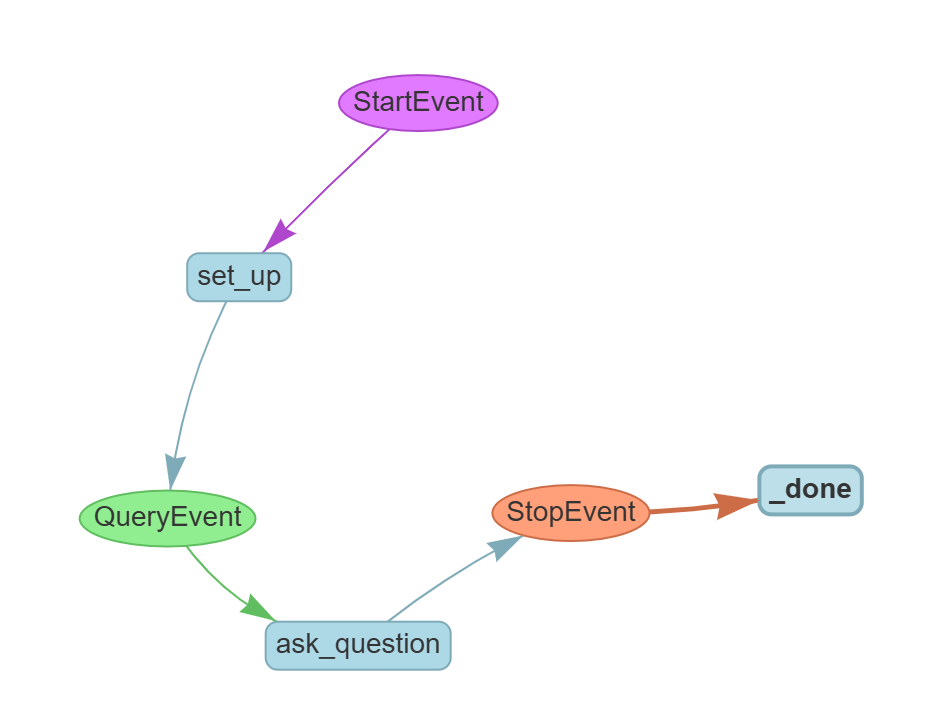

It consists of two steps:
1. `set_up` which is triggered by `StartEvent` and emits `QueryEvent`: at this step, the RAG system is set up and the query is passed to the second step;
2. `ask_question` which is triggered by `QueryEvent` and emits `StopEvent`: here the response to the query is generated using the RAG query engine.

In [30]:
from llama_index.core.workflow import (
    StartEvent,
    StopEvent,
    Workflow,
    step,
    Event,
    Context
)

In [31]:
class QueryEvent(Event):
    query: str

In [36]:
class RAGWorkflow(Workflow):
    storage_dir = "./storage"
#     llm: Grok
    query_engine: VectorStoreIndex

    # the first step will be setup
    @step
    async def set_up(self, ctx: Context, ev: StartEvent) -> QueryEvent:

        if not ev.resume_file:
            raise ValueError("No resume file provided")

        # define an LLM to work with
        self.llm = Groq(model="llama3-70b-8192", api_key=os.environ["GROQ_API_KEY"])

        # ingest the data and set up the query engine
        if os.path.exists(self.storage_dir):
            # you've already ingested your documents
            storage_context = StorageContext.from_defaults(persist_dir=self.storage_dir)
            index = load_index_from_storage(storage_context)
        else:
            # parse and load your documents
            documents = LlamaParse(
                result_type="markdown",
                content_guideline_instruction="This is a resume, gather related facts together and format it as bullet points with headers"
            ).load_data(ev.resume_file)
            # embed and index the documents
            index = VectorStoreIndex.from_documents(
                documents,
                embed_model= HuggingFaceEmbedding(
                model_name="BAAI/bge-small-en-v1.5"
                )
            )
            index.storage_context.persist(persist_dir=self.storage_dir)

        # either way, create a query engine
        self.query_engine = index.as_query_engine(llm=self.llm, similarity_top_k=5)

        # now fire off a query event to trigger the next step
        return QueryEvent(query=ev.query)

    # the second step will be to ask a question and return a result immediately
    @step
    async def ask_question(self, ctx: Context, ev: QueryEvent) -> StopEvent:
        response = self.query_engine.query(f"This is a question about the specific resume we have in our database: {ev.query}")
        return StopEvent(result=response.response)

In [37]:
w = RAGWorkflow(timeout=120, verbose=False)
result = await w.run(
    resume_file="./data/fake_resume.pdf",
    query="Where is the first place the applicant worked?"
)
print(result)

The first place the applicant worked was StartupHub in San Jose, CA, where they held the position of Junior Web Developer from June 2017 to February 2019.


# 4: Form Parsing

Incorporate form parsing to the workflow

we used LlamaParse to parse a resume and included parsing instructions. We'll do that again this time, but with more advanced instructions. This time, we'll get it to read an application form, extract the required fields, and convert them into a structured JSON object. Once we have that, we'll incorporate these steps into the workflow we started building in the last lesson.

## Parsing an Application Form with LlamaParse

Let's create a parser with our new parsing instructions, including formatting instructions.

In [39]:
parser = LlamaParse(
    api_key=llama_cloud_api_key,
    base_url=os.getenv("LLAMA_CLOUD_BASE_URL"),
    result_type="markdown",
    content_guideline_instruction="This is a job application form. Create a list of all the fields that need to be filled in.",
    formatting_instruction="Return a bulleted list of the fields ONLY."
)

In [40]:
result = parser.load_data("data/fake_application_form.pdf")[0]

Started parsing the file under job_id 09d13910-57e8-4a36-a9d7-24e1f44268be


In [42]:
print(result.text)

# Big Tech Co. Job Application Form

# Position: Senior Web Developer C3

Thanks for applying to Big Tech Co.! We are humbled that you would consider working here.

Please fill in the following form to help us get started.

|First Name|Last Name|
|---|---|
|Email|Phone|
|Linkedin| |
|Project Portfolio| |
|Degree|Graduation Date|
|Current Job title|Current Employer|
|Technical Skills| |
|Describe why you’re a good fit for this position|Describe why you’re a good fit for this position|
|Do you have 5 years of experience in React?|Do you have 5 years of experience in React?|


In [44]:
print(llm)

callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x000001F91F59D0D0> system_prompt=None messages_to_prompt=<function messages_to_prompt at 0x000001F911DC2160> completion_to_prompt=<function default_completion_to_prompt at 0x000001F911E95E40> output_parser=None pydantic_program_mode=<PydanticProgramMode.DEFAULT: 'default'> query_wrapper_prompt=None model='llama3-70b-8192' temperature=0.1 max_tokens=None logprobs=None top_logprobs=0 additional_kwargs={} max_retries=3 timeout=60.0 default_headers=None reuse_client=True api_key='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' api_base='https://api.groq.com/openai/v1' api_version='' strict=False reasoning_effort=None modalities=None audio_config=None context_window=3900 is_chat_model=True is_function_calling_model=True tokenizer=None


In [45]:
raw_json = llm.complete(
    f"""
    This is a parsed form.
    Convert it into a JSON object containing only the list 
    of fields to be filled in, in the form {{ fields: [...] }}. 
    <form>{result.text}</form>. 
    Return JSON ONLY, no markdown."""
)

In [47]:
raw_json.text

'{ "fields": ["First Name", "Last Name", "Email", "Phone", "Linkedin", "Project Portfolio", "Degree", "Graduation Date", "Current Job title", "Current Employer", "Technical Skills", "Describe why you’re a good fit for this position", "Do you have 5 years of experience in React?"] }'

In [49]:
import json

fields = json.loads(raw_json.text)["fields"]

for field in fields:
    print(field)

First Name
Last Name
Email
Phone
Linkedin
Project Portfolio
Degree
Graduation Date
Current Job title
Current Employer
Technical Skills
Describe why you’re a good fit for this position
Do you have 5 years of experience in React?


Now that you know how to parse the job application form, you will add this processing to the workflow of lesson 3. You will do that in two steps as shown in this figure:

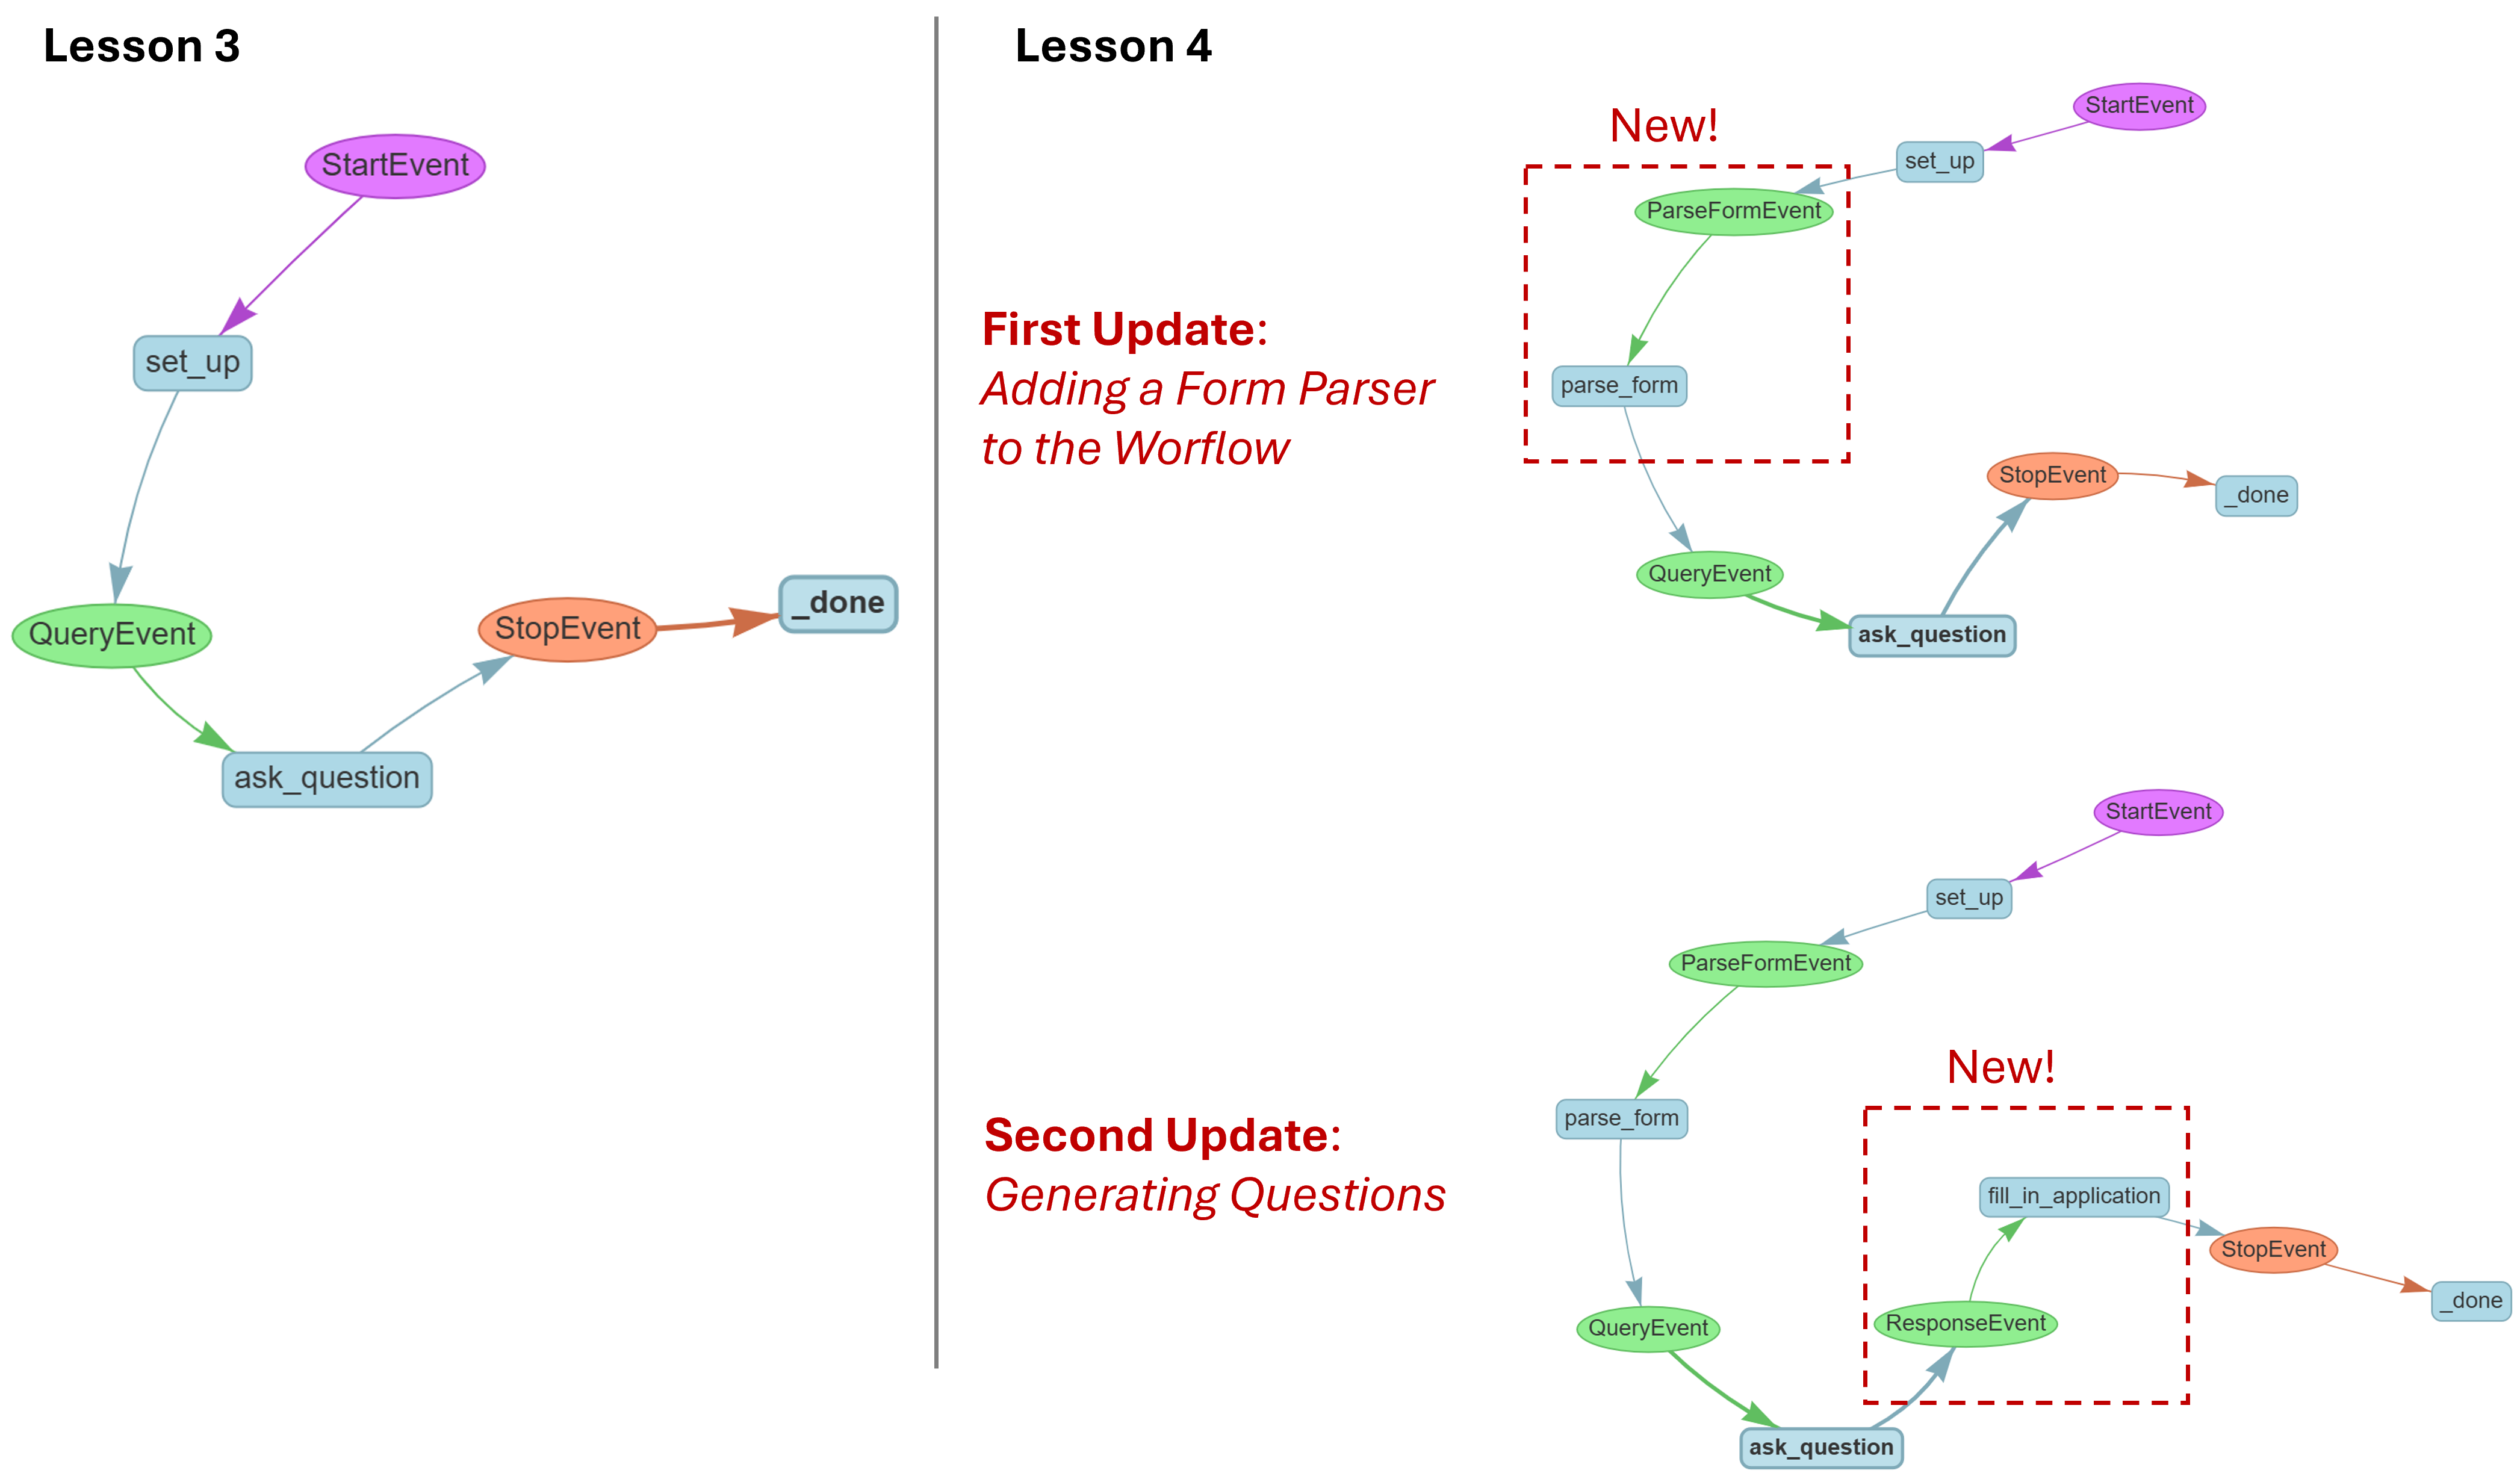

## Adding a Form Parser to the Workflow (first update)

Now let's take the workflow you built in the last lesson and add your parser.

In [50]:
class ParseFormEvent(Event):
    application_form: str

class QueryEvent(Event):
    query: str

Your `set_up` step now emits a `ParseFormEvent` which triggers your new step, `parse_form`. For the moment you can leave the ask_questions step untouched, it will be updated in another section of this notebook.

In [51]:
class RAGWorkflow(Workflow):
    
    storage_dir = "./storage"
#     llm: OpenAI
    query_engine: VectorStoreIndex

    @step
    async def set_up(self, ctx: Context, ev: StartEvent) -> ParseFormEvent:

        if not ev.resume_file:
            raise ValueError("No resume file provided")

        if not ev.application_form:
            raise ValueError("No application form provided")

        # define the LLM to work with
        self.llm = Groq(model="llama3-70b-8192", api_key=os.environ["GROQ_API_KEY"])

        # ingest the data and set up the query engine
        if os.path.exists(self.storage_dir):
            # you've already ingested the resume document
            storage_context = StorageContext.from_defaults(persist_dir=self.storage_dir)
            index = load_index_from_storage(storage_context)
        else:
            # parse and load the resume document
            documents = LlamaParse(
                api_key=llama_cloud_api_key,
                base_url=os.getenv("LLAMA_CLOUD_BASE_URL"),
                result_type="markdown",
                content_guideline_instruction="This is a resume, gather related facts together and format it as bullet points with headers"
            ).load_data(ev.resume_file)
            # embed and index the documents
            index = VectorStoreIndex.from_documents(
                documents,
                embed_model=OpenAIEmbedding(model_name="BAAI/bge-small-en-v1.5")
            )
            index.storage_context.persist(persist_dir=self.storage_dir)

        # create a query engine
        self.query_engine = index.as_query_engine(llm=self.llm, similarity_top_k=5)

        # you no longer need a query to be passed in, 
        # you'll be generating the queries instead 
        # let's pass the application form to a new step to parse it
        return ParseFormEvent(application_form=ev.application_form)

    @step
    async def parse_form(self, ctx: Context, ev: ParseFormEvent) -> QueryEvent:
        parser = LlamaParse(
            api_key=llama_cloud_api_key,
            result_type="markdown",
            content_guideline_instruction="This is a job application form. Create a list of all the fields that need to be filled in.",
            formatting_instruction="Return a bulleted list of the fields ONLY."
        )

        # get the LLM to convert the parsed form into JSON
        result = parser.load_data(ev.application_form)[0]
        raw_json = self.llm.complete(
            f"""
            This is a parsed form. 
            Convert it into a JSON object containing only the list 
            of fields to be filled in, in the form {{ fields: [...] }}. 
            <form>{result.text}</form>. 
            Return JSON ONLY, no markdown.
            """)
        fields = json.loads(raw_json.text)["fields"]

        for field in fields:
            print(field)
        return StopEvent(result="Dummy event")

    # will be edited in the next section
    @step
    async def ask_question(self, ctx: Context, ev: QueryEvent) -> StopEvent:
        response = self.query_engine.query(f"This is a question about the specific resume we have in our database: {ev.query}")
        return StopEvent(result=response.response)

In [52]:
w = RAGWorkflow(timeout=60, verbose=False)
result = await w.run(
    resume_file="data/fake_resume.pdf",
    application_form="data/fake_application_form.pdf"
)

Started parsing the file under job_id d1271c2d-5437-4f76-ab5c-f29af0947ab2
First Name
Last Name
Email
Phone
Linkedin
Project Portfolio
Degree
Graduation Date
Current Job title
Current Employer
Technical Skills
Describe why you’re a good fit for this position
Do you have 5 years of experience in React?


## Generating Questions (second update)

Excellent! Your workflow knows what fields it needs answers for. In this next iteration, you can fire off one `QueryEvent` for each of the fields, so they'll be executed concurrently (we talked about doing concurrent steps in Lesson 2). 

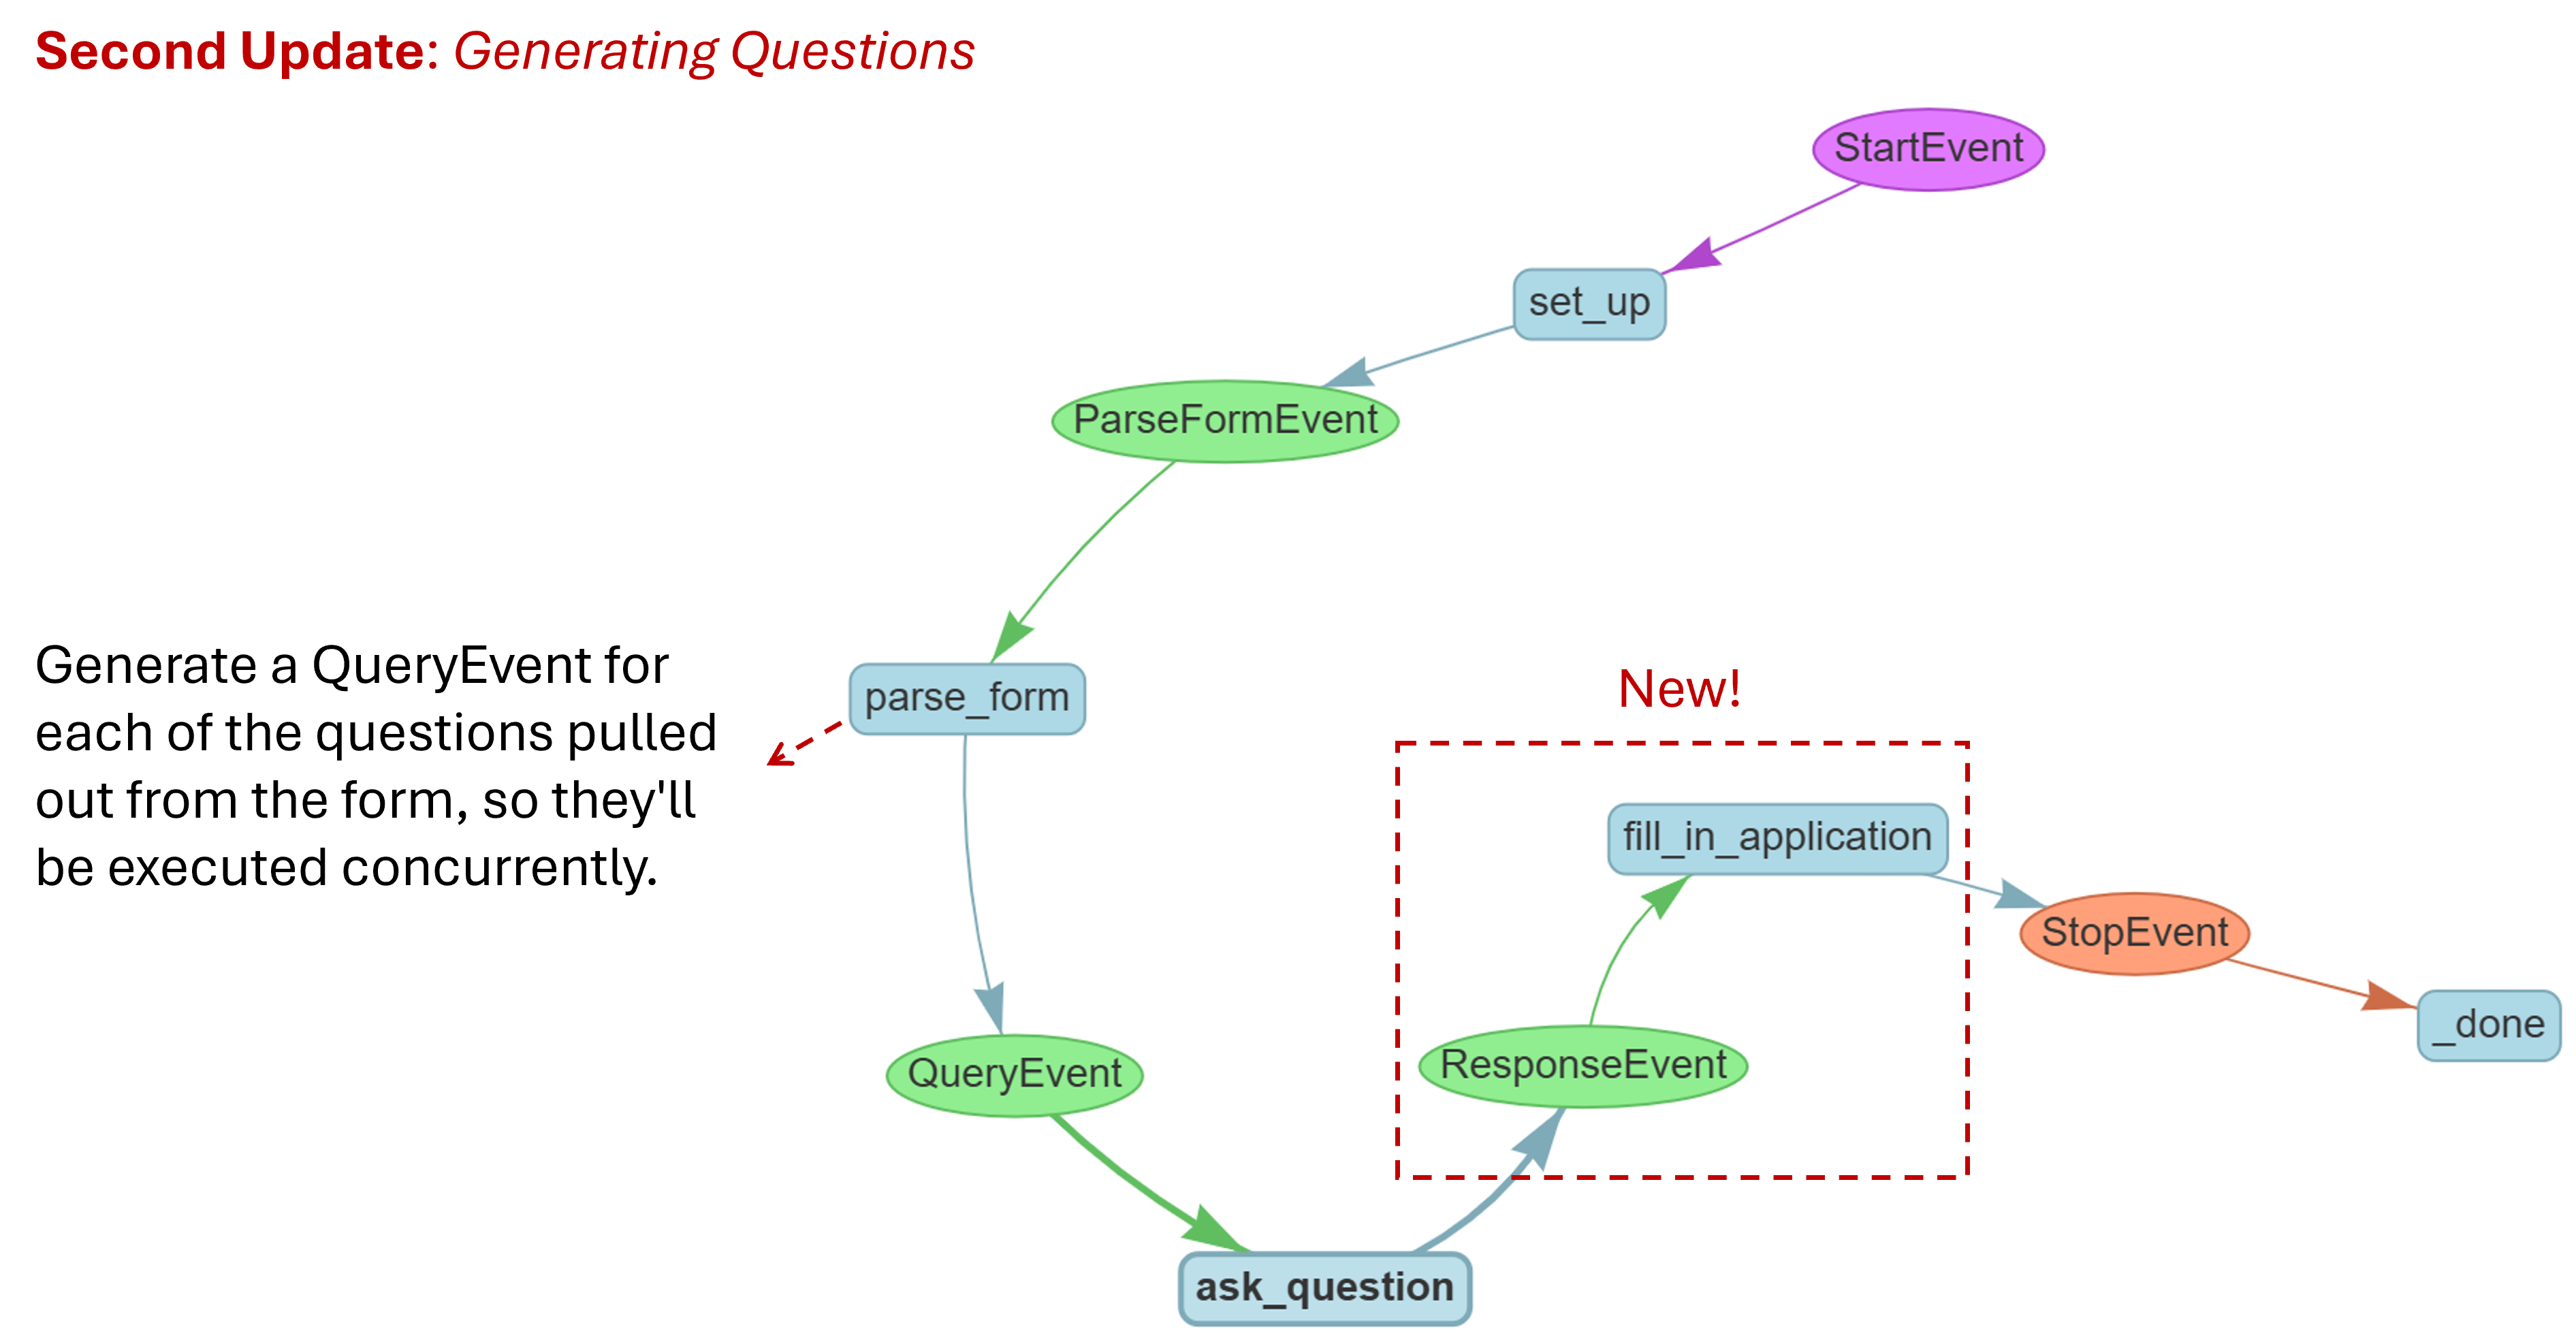

The changes you're going to make are:
* Generate a `QueryEvent` for each of the questions you pulled out of the form
* Create a `fill_in_application` step which will take all the responses to the questions and aggregate them into a coherent response
* Add a `ResponseEvent` to pass the results of queries to `fill_in_application`

In [53]:
class ParseFormEvent(Event):
    application_form: str

class QueryEvent(Event):
    query: str
    field: str

# new!
class ResponseEvent(Event):
    response: str

In [55]:
class RAGWorkflow(Workflow):
    
    storage_dir = "./storage"
#     llm: OpenAI
    query_engine: VectorStoreIndex

    @step
    async def set_up(self, ctx: Context, ev: StartEvent) -> ParseFormEvent:

        if not ev.resume_file:
            raise ValueError("No resume file provided")

        if not ev.application_form:
            raise ValueError("No application form provided")

        # define the LLM to work with
        self.llm = Groq(model="llama3-70b-8192", api_key=os.environ["GROQ_API_KEY"])

        # ingest the data and set up the query engine
        if os.path.exists(self.storage_dir):
            # you've already ingested the resume document
            storage_context = StorageContext.from_defaults(persist_dir=self.storage_dir)
            index = load_index_from_storage(storage_context)
        else:
            # parse and load the resume document
            documents = LlamaParse(
                api_key=llama_cloud_api_key,
                base_url=os.getenv("LLAMA_CLOUD_BASE_URL"),
                result_type="markdown",
                content_guideline_instruction="This is a resume, gather related facts together and format it as bullet points with headers"
            ).load_data(ev.resume_file)
            # embed and index the documents
            index = VectorStoreIndex.from_documents(
                documents,
                embed_model="BAAI/bge-small-en-v1.5"
            )
            index.storage_context.persist(persist_dir=self.storage_dir)

        # create a query engine
        self.query_engine = index.as_query_engine(llm=self.llm, similarity_top_k=5)

        # you no longer need a query to be passed in, 
        # you'll be generating the queries instead 
        # let's pass the application form to a new step to parse it
        return ParseFormEvent(application_form=ev.application_form)

    @step
    async def parse_form(self, ctx: Context, ev: ParseFormEvent) -> QueryEvent:
        parser = LlamaParse(
            api_key=llama_cloud_api_key,
            base_url=os.getenv("LLAMA_CLOUD_BASE_URL"),
            result_type="markdown",
            content_guideline_instruction="This is a job application form. Create a list of all the fields that need to be filled in.",
            formatting_instruction="Return a bulleted list of the fields ONLY."
        )

        # get the LLM to convert the parsed form into JSON
        result = parser.load_data(ev.application_form)[0]
        raw_json = self.llm.complete(
            f"""
            This is a parsed form. 
            Convert it into a JSON object containing only the list 
            of fields to be filled in, in the form {{ fields: [...] }}. 
            <form>{result.text}</form>. 
            Return JSON ONLY, no markdown.
            """)
        fields = json.loads(raw_json.text)["fields"]

        # new!
        # generate one query for each of the fields, and fire them off
        for field in fields:
            ctx.send_event(QueryEvent(
                field=field,
                query=f"How would you answer this question about the candidate? {field}"
            ))

        # store the number of fields so we know how many to wait for later
        await ctx.set("total_fields", len(fields))
        return

    @step
    async def ask_question(self, ctx: Context, ev: QueryEvent) -> ResponseEvent:
        response = self.query_engine.query(f"This is a question about the specific resume we have in our database: {ev.query}")
        return ResponseEvent(field=ev.field, response=response.response)

    # new!
    @step
    async def fill_in_application(self, ctx: Context, ev: ResponseEvent) -> StopEvent:
        # get the total number of fields to wait for
        total_fields = await ctx.get("total_fields")

        responses = ctx.collect_events(ev, [ResponseEvent] * total_fields)
        if responses is None:
            return None # do nothing if there's nothing to do yet

        # we've got all the responses!
        responseList = "\n".join("Field: " + r.field + "\n" + "Response: " + r.response for r in responses)

        result = self.llm.complete(f"""
            You are given a list of fields in an application form and responses to
            questions about those fields from a resume. Combine the two into a list of
            fields and succinct, factual answers to fill in those fields.

            <responses>
            {responseList}
            </responses>
        """)
        return StopEvent(result=result)

In [56]:
w = RAGWorkflow(timeout=120, verbose=False)
result = await w.run(
    resume_file="data/fake_resume.pdf",
    application_form="data/fake_application_form.pdf"
)
print(result)

Started parsing the file under job_id 6d375133-619b-45f6-86d7-d482d7619472
Here is the combined list of fields and succinct, factual answers:

1. **First Name**: Sarah
2. **Last Name**: Chen
3. **Email**: sarah.chen@email.com
4. **Phone**: Not provided
5. **Linkedin**: linkedin.com/in/sarahchen
6. **Project Portfolio**: EcoTrack and ChatFlow (with a portfolio website at sarahchen.dev)
7. **Degree**: Bachelor of Science in Computer Science from the University of California, Berkeley
8. **Graduation Date**: 2017
9. **Current Job title**: Senior Full Stack Developer
10. **Current Employer**: TechFlow Solutions
11. **Technical Skills**: React.js, Redux, Next.js, TypeScript, Vue.js, Nuxt.js, HTML5, CSS3, SASS/SCSS, Jest, React Testing Library, WebPack, Babel, Node.js, Express.js, Python, Django, GraphQL, REST APIs, PostgreSQL, MongoDB, Docker, Kubernetes, AWS, Git, GitHub Actions, Jenkins, CircleCI, Agile/Scrum methodology
12. **Describe why you’re a good fit for this position**: (Not a fac

## Workflow Visualization

You can visualize the workflow you just created.

In [58]:
WORKFLOW_FILE = "form_parsing_workflow.html"
draw_all_possible_flows(w, filename=WORKFLOW_FILE)
html_content = extract_html_content(WORKFLOW_FILE)
display(HTML(html_content), metadata=dict(isolated=True))

<class 'NoneType'>
<class '__main__.ResponseEvent'>
<class 'llama_index.core.workflow.events.StopEvent'>
<class '__main__.QueryEvent'>
<class '__main__.ParseFormEvent'>
form_parsing_workflow.html


# Lesson 5: Human in the Loop

**Lesson objective**: Get feedback on answers from a human operator

In this lab, you’ll learn how to make Workflows easy to iterate on answers to the questionnaire by getting feedback on answers from the human operator and re-answering when necessary.

## Adding a feedback loop

Here's what you built in lesson 4:

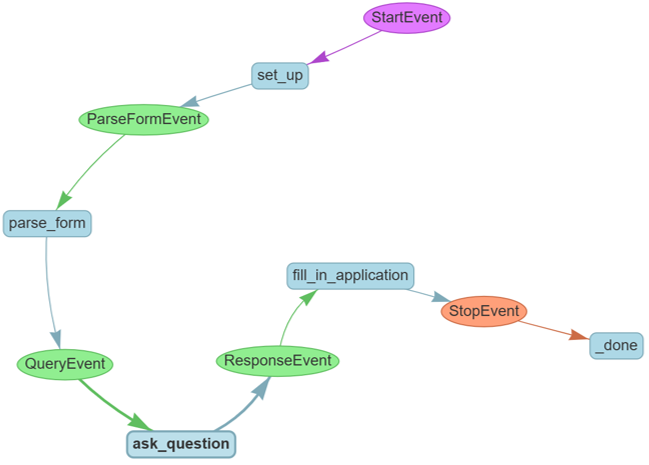

LLMs are amazing, but they are best used to augment rather than replace a human. Your current form-filler does an excellent job figuring out what fields need to be filled in, and gets most of the fields right, but there are a couple where it needs a little help. To take care of those, you'll create a "human in the loop" workflow, where you can optionally provide feedback to the agent you've created and have it incorporated into the results.

This is what you'll implement in this notebook:

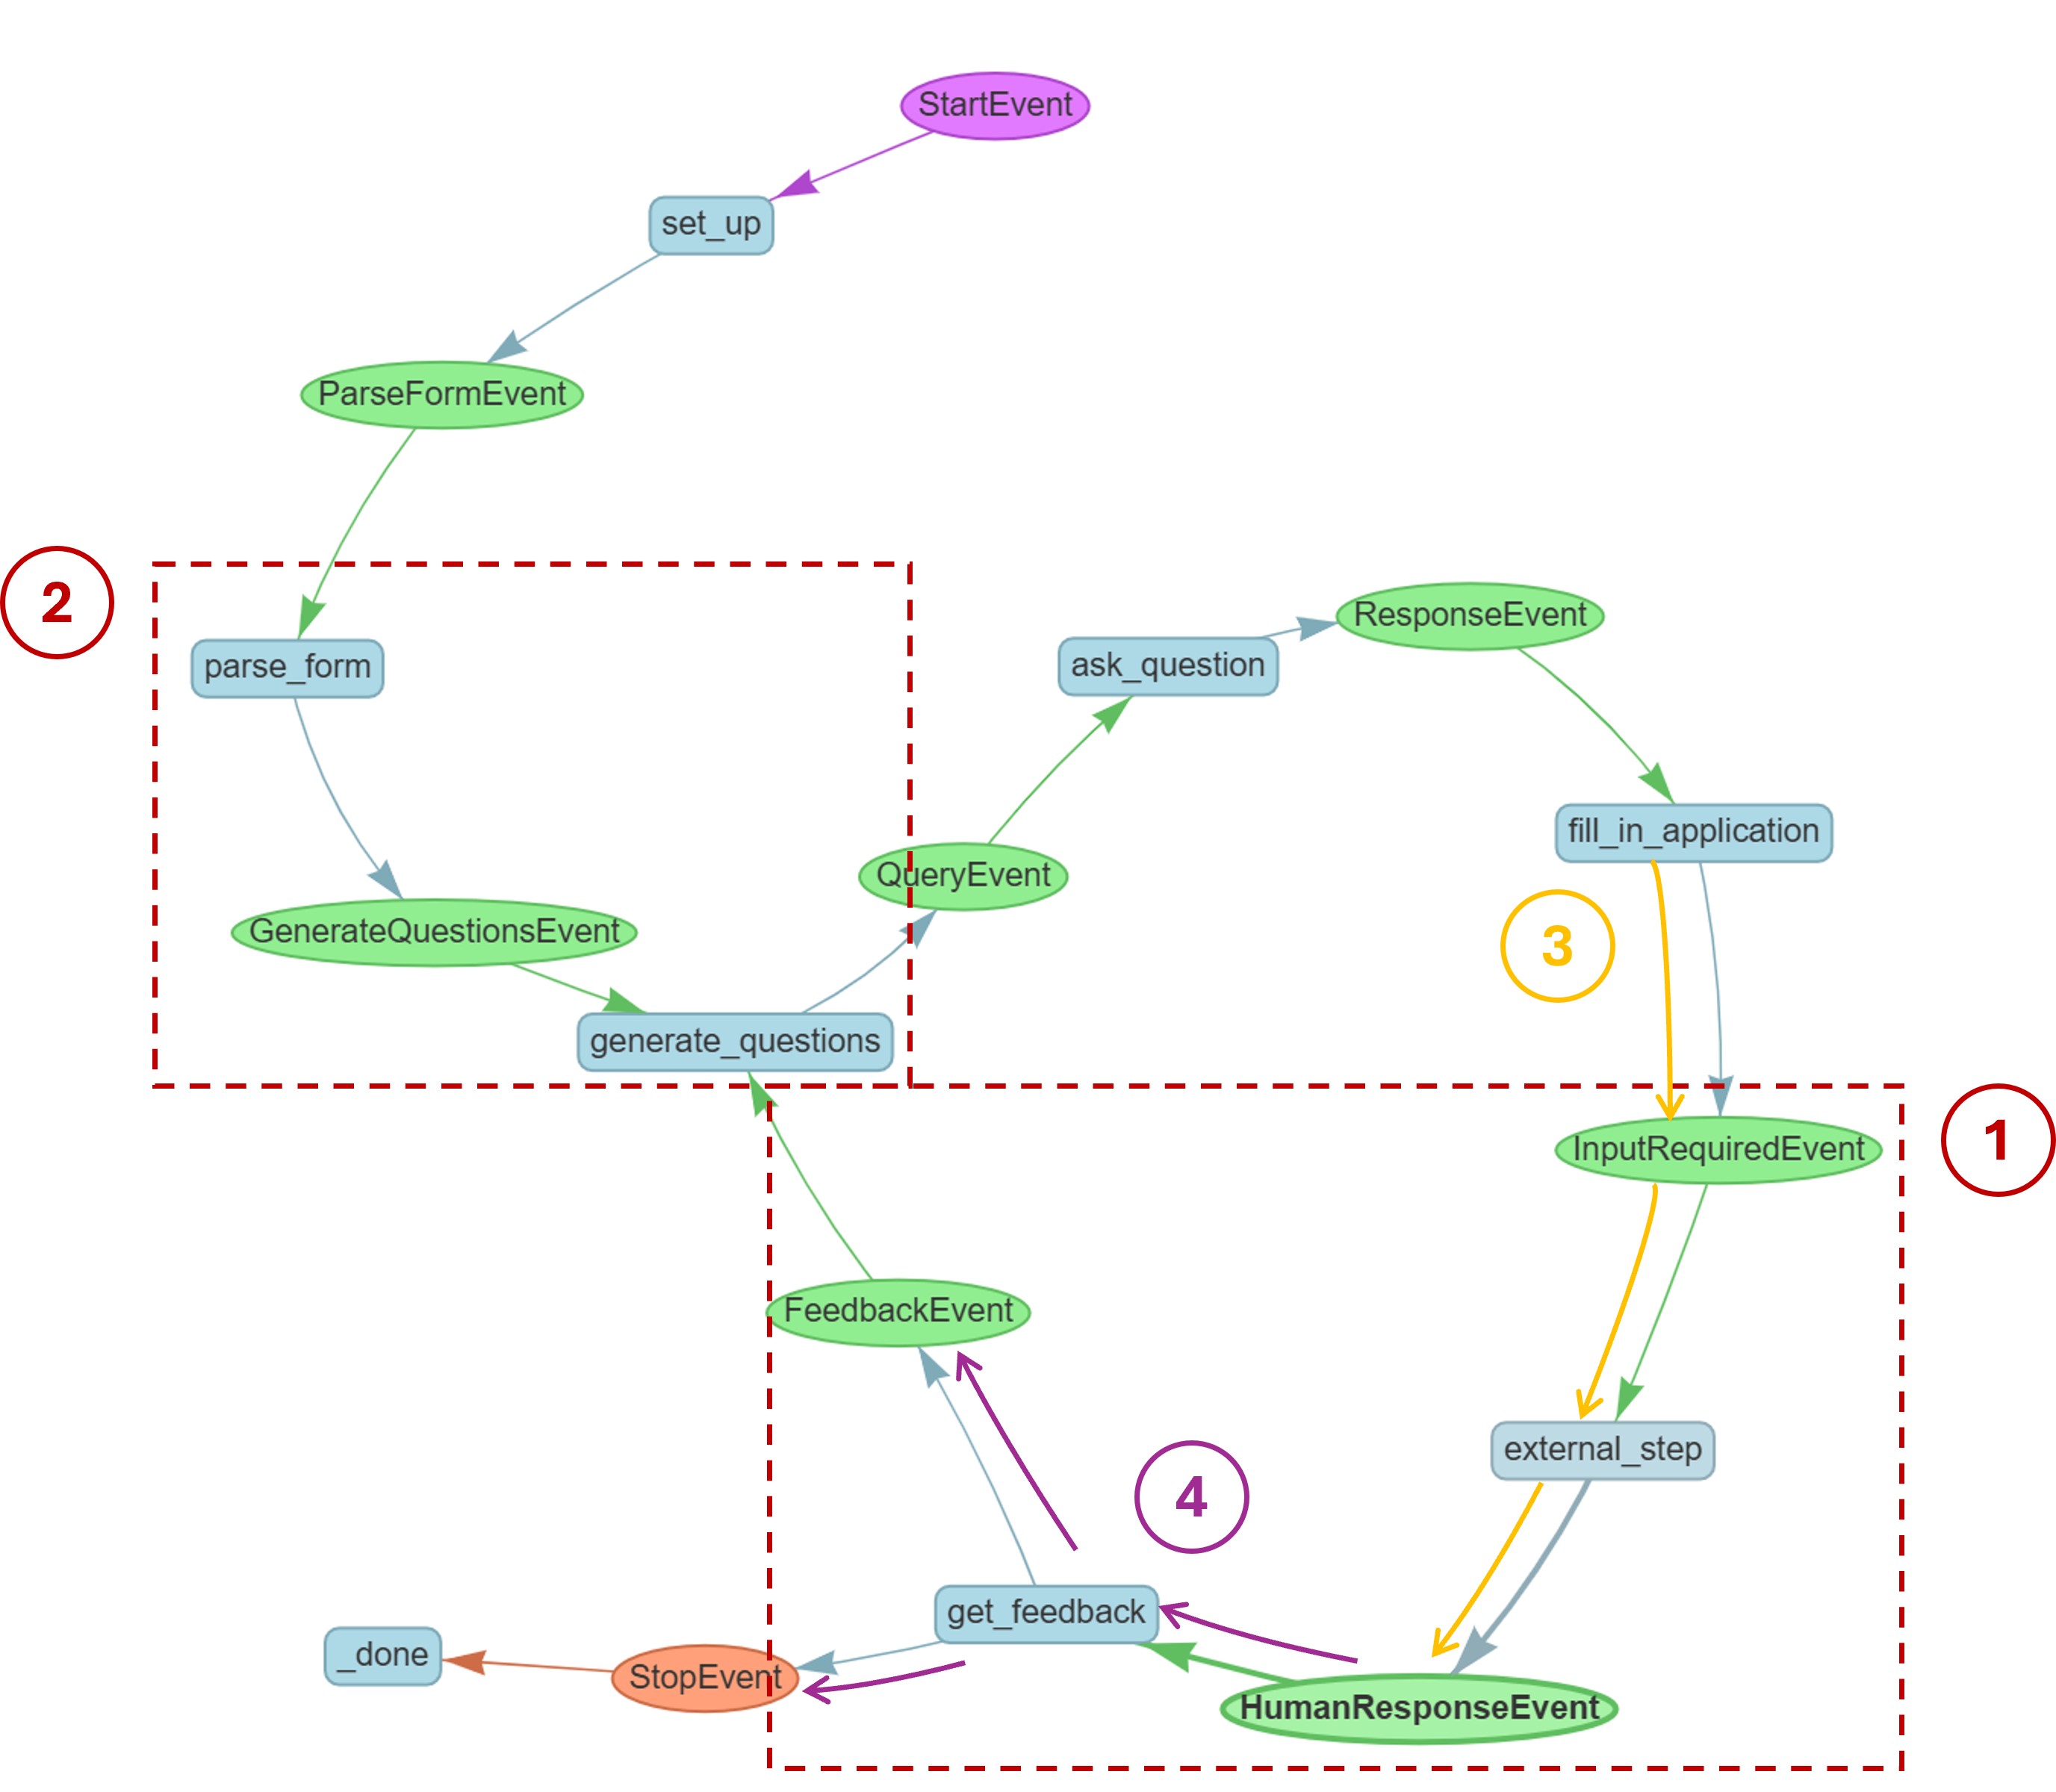

The changes you're going to make here are:
1. Use the `InputRequiredEvent` and `HumanResponseEvent`, new special events specifically designed to allow you to exit the workflow, and get feedback back into it.
2. You used to have a single step which parsed your form and fired off all your questions. Since we now might loop back and ask questions several times, we don't need to parse the form every time, so we'll split up those steps. This kind of refactoring is very common as you create a more complex workflow:
   - Your new `generate_questions` step will be triggered either by a `GenerateQuestionsEvent`, triggered by the form parser, or by a `FeedbackEvent`, which is the loop we'll take after getting feedback.
3. `fill_in_application` will emit an `InputRequiredEvent`, and in the `external_step` you'll wait for a `HumanResponseEvent`. This will pause the whole workflow waiting for outside input.
4. Finally, you'll use the LLM to parse the feedback and decide whether it means you should continue and output the results, or if you need to loop back.